# Quantum-State Reconstruction by Maximizing Likelihood and Entropy

In this notebook we are writing the algorithm developed in the paper "Quantum-State Reconstruction by Maximizing Likelihood and Entropy". It is intended to estiamate an initial quantum state using the Maximum Likelihood-Maximum Entropy (MLME) estimator. We will program it and try it to see how useful it can be.

In [1]:
import numpy as np
import qibo
import matplotlib.pyplot as plt #(pip install ipykernel==5.5.5) in case it does not work
from itertools import product
from qibo.models import QFT
from qibo.models import Circuit
from qibo import gates
from scipy.stats import unitary_group

In [136]:
def rho_MLME(probabilities, POVM, lam, nqubits):
    """Estimates the density matrix of the state by the Maximum
       Likelihood-Maximum Entropy (MLME) estimator.

        Attributes:
            probabilities (list): contains the probabilities of the outcomes,
                which are given by $f_j = n_j/N$, approximation of the ones
                obtained by the expected value of the POVM E_j.
            POVM (list): set of operators that represent a POVM.
            lam (float): weight on the entropy during the optimization.
            nqubits (int): number of qubits.  
    """

    f = probabilities
    I = np.eye(2**nqubits)
    E = POVM
    epsilon = 0.1

    rho = np.ones(shape=(2**nqubits,2**nqubits))
    R=0
    for j in range(len(f)):
        p_j = np.trace(rho@E[j])
        R += (f[j]/p_j)*E[j]

    T = R - I - lam*(np.log2(rho) - np.trace(rho*np.log2(rho)))
                     
    precision = np.matmul(T, rho) - np.matmul(rho, T)

    while  np.all(np.abs(precision) > 10**(-14)):
    #for _ in range(1000):
        R=0
        for j in range(len(f)):
            p_j = np.trace(rho@E[j])
            R += (f[j]/p_j)*E[j]

        T = R - I - lam*(np.log2(rho) - np.trace(rho*np.log2(rho)))
        A = (I + epsilon*T)@rho@(I + epsilon*T)
        rho = A/np.trace(A)
        precision = np.matmul(T, rho) - np.matmul(rho, T)
        
    return rho

In [4]:
#let's try to make a random POVM
import scipy as sc

def random_ginibre(n, m, real=False):
	return (np.random.randn(n, m) + 1j*np.random.randn(n,m))/np.sqrt(2) if not real else np.random.randn(n, m)/np.sqrt(2)

def random_haar_povm(d, k=None, n=1, real=False):
    """Generates a Haar distributed random POVM for a Hilbert space of dimension $d$, with $k$ elements, and with "mixedness" $n$.
    $n$ must satisfy $d \leq kn$, and defaults to $n=1$, giving rank-1 POVM elements.

    $k$ defaults to $d^2$ if complex, $\frac{d(d+1)}{2}$ if real.
    Check https://heyredhat.github.io/qbism/05random.html#random_haar_effect for more info.
    """
    k = k if type(k) != type(None) else (d**2 if not real else int(d*(d+1)/2))
    povm = np.zeros((k, d, d), dtype=np.complex128) if not real else np.zeros((k, d, d))
    S = np.zeros(d, dtype=np.complex128) if not real else np.zeros(d)
    for i in range(k):
        Xi = random_ginibre(d, n, real=real)
        Wi = Xi @ Xi.conjugate().T
        povm[i, :, :] = Wi
        S = S + Wi
    S = sc.linalg.fractional_matrix_power(S, -1/2)
    for i in range(k):
        Wi = np.squeeze(povm[i, :, :])
        povm[i, :, :] = S @ Wi @ S
    return povm

In [106]:
from qibo.quantum_info import random_unitary
from qibo.quantum_info import fidelity

def pseudorandom_circuit(nqubits, density_matrix=None ):
    c = Circuit(nqubits, density_matrix=density_matrix)
    for i in range(nqubits):
        haar_U = random_unitary(2, measure='haar')
        c.add(gates.Unitary(haar_U, i))
    for i in range(nqubits-1):
        c.add(gates.CNOT(i,i+1))
    for i in range(nqubits):
        haar_U = random_unitary(2, measure='haar')
        c.add(gates.Unitary(haar_U, i))
    return c

In [113]:
nqubits = 2
dim_povm = 100

POVM = random_haar_povm(d=2**nqubits,k=dim_povm, n=nqubits)
random_U = unitary_group.rvs(2)

c = pseudorandom_circuit(nqubits, density_matrix=True)

final = c()

f = []
for j in range(len(POVM)):
    p = np.trace(POVM[j]@final)
    f.append(p) #ideal value
    #f.append(np.random.normal(p,0.001)) #value with gaussian noise

print(final)
print(f)
print(np.sum(f))

(0.19923+0j)|00><00| + (0.22794-0.00407j)|00><01| + (-0.16971+0.11752j)|00><10| + (-0.19467-0.1645j)|00><11| + (0.22794+0.00407j)|01><00| + (0.26087-0j)|01><01| + (-0.19657+0.13098j)|01><10| + (-0.21935-0.19218j)|01><11| + (-0.16971-0.11752j)|10><00| + (-0.19657-0.13098j)|10><01| + (0.21388+0j)|10><10| + (0.06879+0.25495j)|10><11| + (-0.19467+0.1645j)|11><00| + (-0.21935+0.19218j)|11><01| + (0.06879-0.25495j)|11><10| + (0.32602+0j)|11><11|
[(0.014878545630268709+2.168404344971009e-18j), (0.019266151510331585+8.673617379884035e-19j), (0.005225786875427982+0j), (0.006092296072663338+8.673617379884035e-19j), (0.018745229657792163+8.673617379884035e-19j), (0.018918842268277256-1.734723475976807e-18j), (0.015515295896608312-2.168404344971009e-19j), (0.004446242486752699+8.673617379884035e-19j), (0.0029983898841692775+1.0299920638612292e-18j), (0.03871865686212456+1.734723475976807e-18j), (0.0017640532443562447+8.673617379884035e-19j), (0.01269192842635169-4.336808689942018e-19j), (0.0068907

In [118]:
estimation = rho_MLME(f, POVM, 0.00001,2)

print(estimation)
print(final - estimation)
print(fidelity(estimation, np.array(final)))

[[ 0.19922192+1.95154192e-12j  0.2279364 -4.07988808e-03j
  -0.16971321+1.17502037e-01j -0.1946881 -1.64463182e-01j]
 [ 0.2279364 +4.07988807e-03j  0.26087314+2.22391883e-11j
  -0.19658085+1.30962397e-01j -0.21938105-1.92154816e-01j]
 [-0.16971321-1.17502036e-01j -0.19658085-1.30962397e-01j
   0.21387859-3.36881614e-12j  0.06884978+2.54930903e-01j]
 [-0.1946881 +1.64463182e-01j -0.21938105+1.92154816e-01j
   0.06884978-2.54930903e-01j  0.32602635-2.08219141e-11j]]
[[ 1.23298367e-05-1.95154192e-12j  4.22110608e-06+5.49013110e-06j
   3.04240875e-06+1.95949613e-05j  2.28515592e-05-3.30195473e-05j]
 [ 4.22113861e-06-5.49011434e-06j -6.71055001e-06-2.22391952e-11j
   1.48879256e-05+2.15418245e-05j  3.17392280e-05-2.35376474e-05j]
 [ 3.04243488e-06-1.95949828e-05j  1.48879801e-05-2.15419222e-05j
   4.69562885e-06+3.36884390e-12j -6.23514085e-05+1.55068361e-05j]
 [ 2.28515231e-05+3.30195282e-05j  3.17391436e-05+2.35376245e-05j
  -6.23513745e-05-1.55068114e-05j -1.03149156e-05+2.08219418e-11j]

In [146]:
#check scale with nqubits and fixed POVM size
nqubits = [2,3,4,5]
dim_povm = 1000
fidelities = []

for i in nqubits:
    POVM = random_haar_povm(d=2**i,k=dim_povm, n=i)
    c = pseudorandom_circuit(i, density_matrix=True)

    final = c()

    f = []
    for j in range(len(POVM)):
        p = np.trace(POVM[j]@final)
        f.append(p) #ideal value
        #f.append(np.random.normal(p,0.001)) #value with gaussian noise
    print(np.sum(f))

    estimation = rho_MLME(f, POVM, 0.00001,i)
    fid = fidelity(estimation, np.array(final))
    fidelities.append(fid)

(0.9999999999999944-1.2882354688201203e-16j)
(0.9999999999999993-1.7181893928464032e-16j)
(1.0000000000000038-3.7468502421793975e-17j)
(1.0000000000000004+1.3315866150605954e-16j)


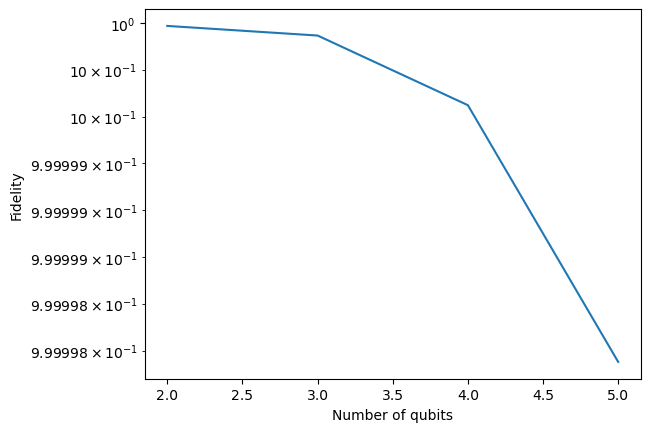

In [159]:
plt.plot(nqubits, fidelities)
plt.xlabel('Number of qubits')
plt.ylabel('Fidelity')
plt.yscale('log')
plt.show()

In [161]:
#check scale with POVM and fixed nqubits
nqubits = 2
dim_povm = [10,100,1000,10000]
fidelities = []

for dim in dim_povm:
    POVM = random_haar_povm(d=2**nqubits,k=dim, n=nqubits)
    c = pseudorandom_circuit(nqubits, density_matrix=True)

    final = c()

    f = []
    for j in range(len(POVM)):
        p = np.trace(POVM[j]@final)
        f.append(p) #ideal value
        #f.append(np.random.normal(p,0.001)) #value with gaussian noise
    print(np.sum(f))

    estimation = rho_MLME(f, POVM, 0.00001,nqubits)
    fid = fidelity(estimation, np.array(final))
    fidelities.append(fid)

(0.9999999999999949+3.0487765090292385e-16j)
(1.0000000000000036+9.424427384330247e-17j)
(1.000000000000008-1.5568804383712942e-16j)
(1.000000000000007-9.748166023748801e-17j)


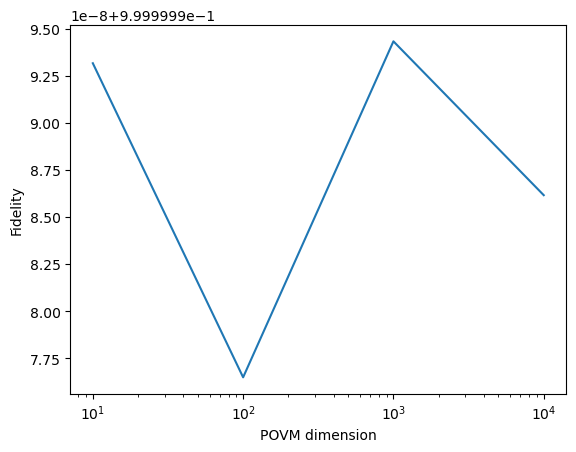

In [166]:
plt.plot(dim_povm, fidelities)
plt.xlabel('POVM dimension')
plt.ylabel('Fidelity')
plt.xscale('log')
plt.show()

I tried to check how the method scales with the number of qubits and POVM, while truncating some error during the optimization steps. It seems that we have some exponential decay as the number of qubits increses. We should expect to find better results if we increse the POVM dimension, aswe would have more information on the quantum state. However, the amount of data needed increses too much (probably exponentialy with the number of POVMs).